In [134]:
# Import of necessary libraries

import sqlite3 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [160]:
conn = sqlite3.connect(r"C:\Users\MSI\Desktop\papcorn.db")

# 1. Calculate the total revenue generated from subscriptions for each country.

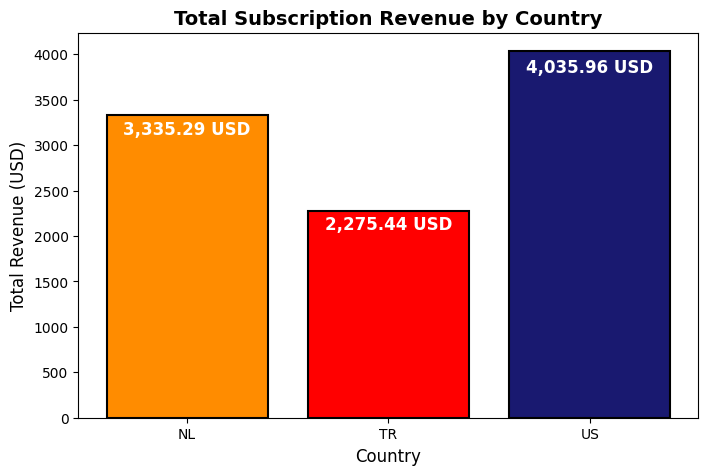

In [152]:
# I enter the query we prepared over SQLite.
query = """
SELECT 
    u.country, 
    ROUND(SUM(e.amount_usd), 2) AS total_revenue
FROM user_events e
JOIN users u ON e.user_id = u.id
WHERE e.event_name IN ('subscription_started', 'subscription_renewed')
GROUP BY u.country;
"""

# I assign the result of the query to a variable.
df = pd.read_sql_query(query, conn)

# Visualization with Bar Chart using Matplotlib library
plt.figure(figsize=(8, 5))
bars = plt.bar(df['country'], df['total_revenue'], 
               color=['darkorange', 'red', 'midnightblue'], 
               edgecolor="black", linewidth=1.5)

# Adding values inside the bars.
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, 
             height * 0.98, 
             f'{height:,.2f} USD', 
             ha='center', va='top', 
             fontsize=12, fontweight='bold', color='white')

# Title settings
plt.xlabel("Country", fontsize=12)
plt.ylabel("Total Revenue (USD)", fontsize=12)
plt.title("Total Subscription Revenue by Country", fontsize=14, fontweight='bold')

plt.show()

# 2. Calculate the total number of trials given to users who came from Instagram.

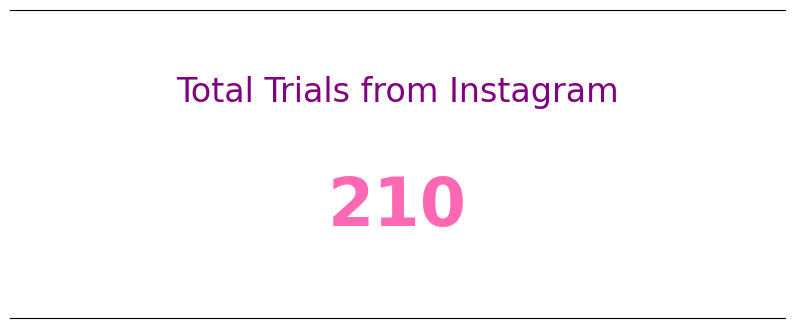

In [153]:
query_trials = """
SELECT COUNT(*) AS total_trials
FROM user_events
JOIN users ON user_events.user_id = users.id
WHERE event_name = 'trial_started' 
AND attribution_source = 'instagram';
"""
df_trials = pd.read_sql_query(query_trials, conn)

total_trials_instagram = df_trials["total_trials"][0]

# Creating a Chart
fig, ax = plt.subplots(figsize=(10, 4))
ax.text(0.5, 0.7, "Total Trials from Instagram", fontsize=24, ha='center', color="purple")
ax.text(0.5, 0.3, f"{total_trials_instagram:,}", fontsize=48, fontweight='bold', ha='center', color="hotpink")

# Frame adjustments
ax.set_xticks([])
ax.set_yticks([])
#ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
#ax.spines["bottom"].set_visible(False)

plt.show()

# 3. Create a new column named 'acquisition_channel' by categorizing users based on their 'attribution_source'

'Paid': users from instagram or tiktok |  'Organic': users from organic sources

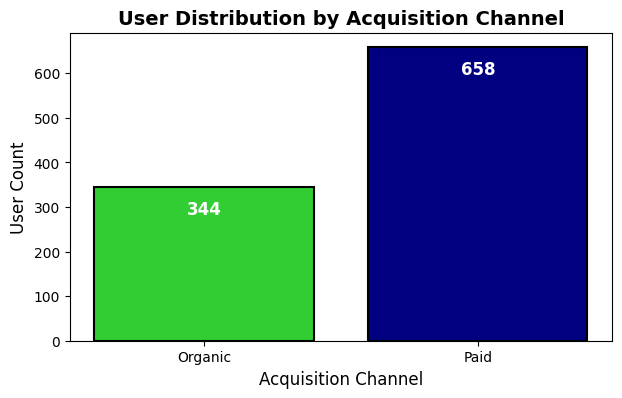

In [154]:
query_acquisition = """
SELECT acquisition_channel, COUNT(id) AS user_count
FROM users
GROUP BY acquisition_channel;
"""

df_acq = pd.read_sql_query(query_acquisition, conn)

plt.figure(figsize=(7, 4))
bars = plt.bar(df_acq["acquisition_channel"], df_acq["user_count"], 
               color=["limegreen", "navy"], edgecolor="black", linewidth=1.5) 

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height - 50,
             f"{int(height):,}",
             ha='center', va='center',
             fontsize=12, fontweight='bold', color='white')

plt.xlabel("Acquisition Channel", fontsize=12)
plt.ylabel("User Count", fontsize=12)
plt.title("User Distribution by Acquisition Channel", fontsize=14, fontweight='bold')

plt.show()

# 4. Analyze the trial-to-subscription conversion rate:


## 4.a Calculate the overall conversion rate

P.S.: I calculated it by considering that each user is given 1 trial. While deciding here, the company's policy will be the priority, followed by the joint decision we take with our teammates.

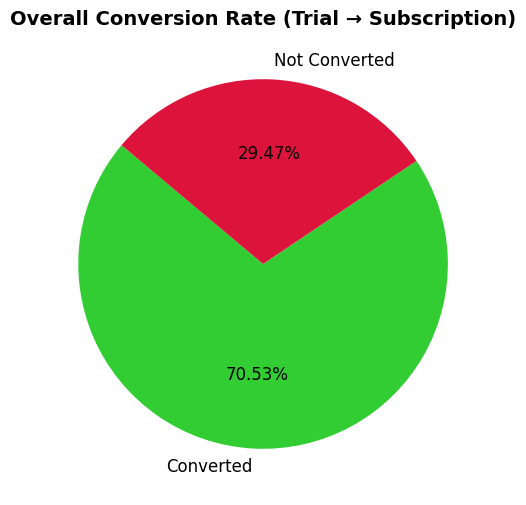

In [155]:
query_overall = """
WITH trial_users AS (
    SELECT DISTINCT user_id
    FROM user_events
    WHERE event_name = 'trial_started'
),
first_subscriptions AS (
    SELECT user_id, MIN(created_at) AS first_subscription_date
    FROM user_events
    WHERE event_name = 'subscription_started'
    GROUP BY user_id
)
SELECT 
    COUNT(DISTINCT f.user_id) AS converted_users,
    COUNT(DISTINCT t.user_id) AS total_trials
FROM trial_users t
LEFT JOIN first_subscriptions f ON t.user_id = f.user_id;
"""
df_overall = pd.read_sql_query(query_overall, conn)

converted = df_overall["converted_users"][0]
not_converted = df_overall["total_trials"][0] - converted
labels = ["Converted", "Not Converted"]
sizes = [converted, not_converted]
colors = ["limegreen", "crimson"]

# Pie Chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.2f%%", colors=colors, startangle=140, textprops={'fontsize': 12})
plt.title("Overall Conversion Rate (Trial → Subscription)", fontsize=14, fontweight="bold")
plt.show()

## 4.b Break down the conversion rate by attribution_source

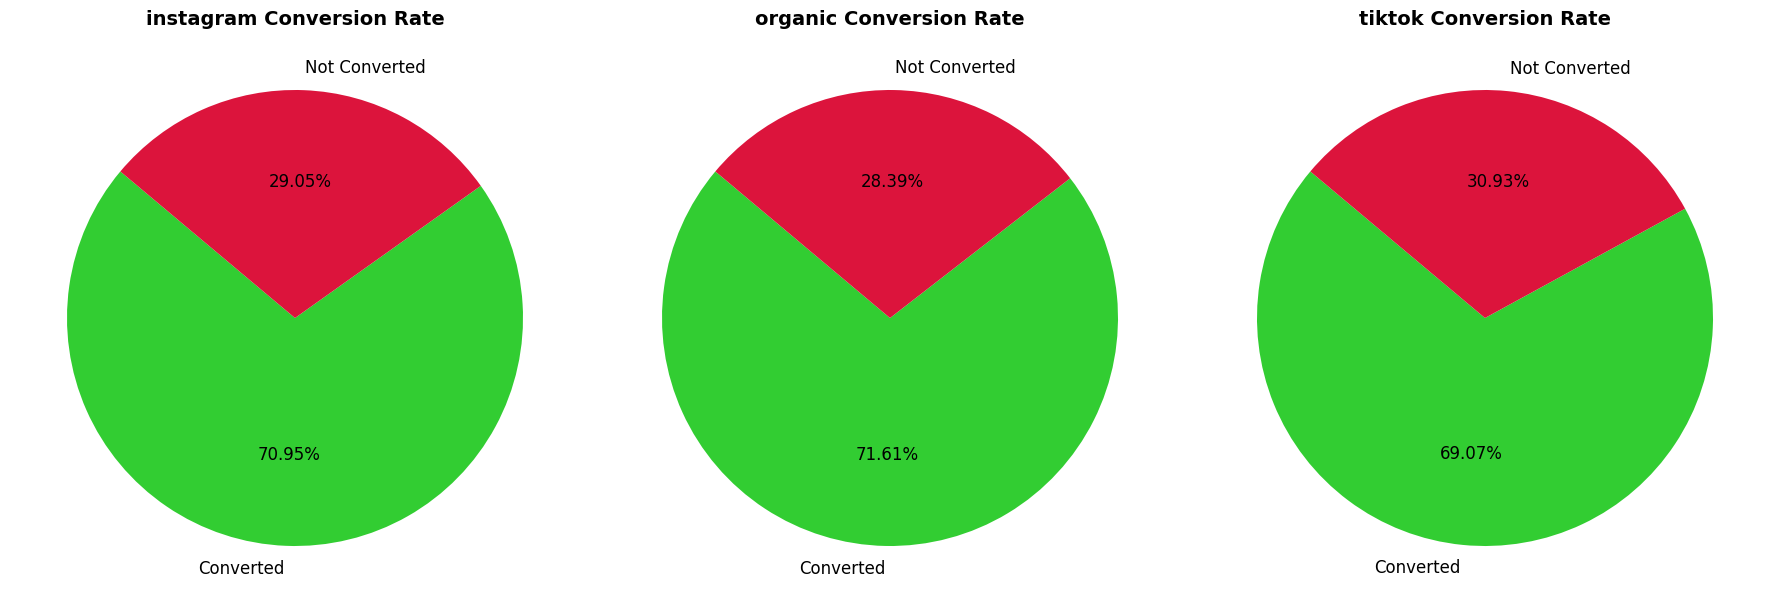

In [156]:
query_attribution = """
WITH trial_users AS (
    SELECT DISTINCT u.id AS user_id, u.attribution_source
    FROM user_events e
    JOIN users u ON e.user_id = u.id
    WHERE e.event_name = 'trial_started'
),
first_subscriptions AS (
    SELECT user_id, MIN(created_at) AS first_subscription_date
    FROM user_events
    WHERE event_name = 'subscription_started'
    GROUP BY user_id
)
SELECT 
    t.attribution_source,
    COUNT(DISTINCT f.user_id) AS converted_users,
    COUNT(DISTINCT t.user_id) AS total_trials
FROM trial_users t
LEFT JOIN first_subscriptions f ON t.user_id = f.user_id
GROUP BY t.attribution_source;
"""
df_attribution = pd.read_sql_query(query_attribution, conn)


# Pie Chart under 3 headings according to attribution_sources
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, source in enumerate(df_attribution["attribution_source"]):
    converted = df_attribution.loc[i, "converted_users"]
    total_trials = df_attribution.loc[i, "total_trials"]
    not_converted = total_trials - converted

    sizes = [converted, not_converted]
    labels = ["Converted", "Not Converted"]
    colors = ["limegreen", "crimson"]

    axes[i].pie(sizes, labels=labels, autopct="%1.2f%%", colors=colors, startangle=140, textprops={'fontsize': 12})
    axes[i].set_title(f"{source} Conversion Rate", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.show()

# 5. Calculate the median subscription duration (in months) for each country

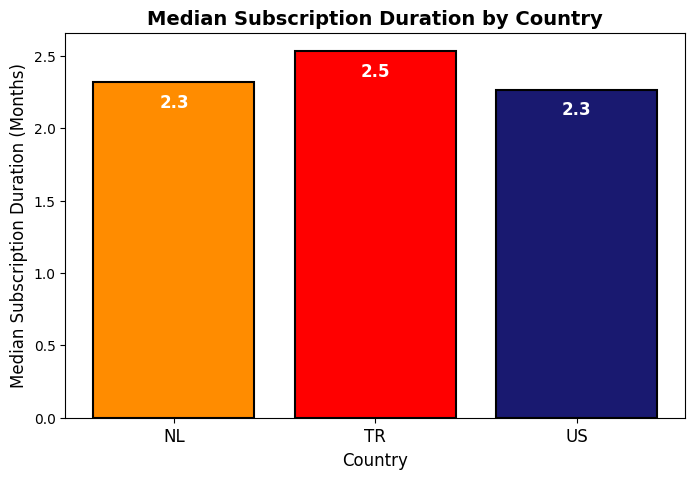

In [157]:
query_median_duration = """
WITH subscription_data AS (
    SELECT 
        e.user_id,
        u.country,
        e.created_at AS subscription_start,
        LEAD(e.created_at) OVER (PARTITION BY e.user_id ORDER BY e.created_at) AS subscription_end
    FROM user_events e
    JOIN users u ON e.user_id = u.id
    WHERE e.event_name IN ('subscription_started', 'subscription_cancelled')
)
SELECT 
    country,
    user_id,
    (JULIANDAY(subscription_end) - JULIANDAY(subscription_start)) / 30.0 AS subscription_duration_months
FROM subscription_data
WHERE subscription_end IS NOT NULL;
"""

df_med_dur = pd.read_sql_query(query_median_duration, conn)

# Calculate the median of subscription_duration
median_durations = df_med_dur.groupby("country")["subscription_duration_months"].median().reset_index()

plt.figure(figsize=(8, 5))

x = np.arange(len(median_durations["country"]))

bars = plt.bar(x, median_durations["subscription_duration_months"], 
               color=['darkorange', 'red', 'midnightblue'], edgecolor="black", linewidth=1.5)

plt.xticks(x, median_durations["country"], fontsize=12)

plt.xlabel("Country", fontsize=12)
plt.ylabel("Median Subscription Duration (Months)", fontsize=12)
plt.title("Median Subscription Duration by Country", fontsize=14, fontweight='bold')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height - 0.2,
             f'{height:.1f}',
             ha='center', va='bottom',
             fontsize=12, fontweight='bold', color='white')

plt.show()

# 6. Calculate the Average Lifetime Value (LTV) by country

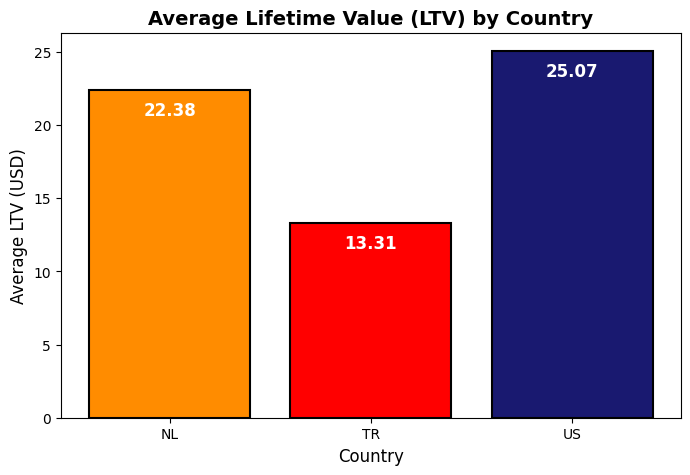

In [158]:
query_ltv = """
SELECT u.country, 
       (SUM(e.amount_usd) * 1.0 / COUNT(DISTINCT u.id)) AS avg_ltv
FROM user_events e
JOIN users u ON e.user_id = u.id
WHERE e.event_name IN ('subscription_started', 'subscription_renewed')
GROUP BY u.country;
"""
df_ltv = pd.read_sql_query(query_ltv, conn)

plt.figure(figsize=(8, 5))

bars = plt.bar(df_ltv["country"], df_ltv["avg_ltv"], 
               color=['darkorange', 'red', 'midnightblue'], 
               edgecolor="black", linewidth=1.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height - 2,
             f'{height:.2f}',
             ha='center', va='bottom',
             fontsize=12, fontweight='bold', color='white')

plt.xlabel("Country", fontsize=12)
plt.ylabel("Average LTV (USD)", fontsize=12)
plt.title("Average Lifetime Value (LTV) by Country", fontsize=14, fontweight='bold')

plt.show()

In [159]:
conn.close()